In [1]:
from pathlib import Path
if Path.cwd().parent.stem == 't1':
    %cd ..

/home/step/Personal/UCH/2021-sem1/VisionComp/t1


In [2]:
import train
from train import *
from dataset import ClothingSmall, parse_function, train_preprocess
import matplotlib.pyplot as plt

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [3]:
print(train.__doc__)


jsaavedr, 2020
This allows you to train and test your model

Before using this program, set the path where the folder "covnet2"  is stored.
To use train.py, you will require to send the following parameters :
 * -config : A configuration file where a set of parameters for data construction and trainig is set.
 * -name: A section name in the configuration file.
 * -mode: [train, test] for training, testing, or showing  variables of the current model. By default this is set to 'train'
 * -save: Set true for saving the model


 Extension made by Victor Faraggi, 2021

 Added modularity. Now you can import the following functions:
    - create_config(name, config_file=None, config_str=None)
        -> return a ConfigurationFile from config_file path or config_str
    - parse_config(config)
        -> returns dict w/ tfr_files
    - load_dataset(config, tfr_train_file, tfr_test_file)
        -> returns a dict w/ train/test datasets, mean_image, input_shape and number_of_classes
    - create

# AlexNet


In [4]:
alexnet_config = \
"""[FASHION-ALEXNET]
# Training Related
NUM_EPOCHS = 20
NUM_CLASSES = 19
BATCH_SIZE = 128
SNAPSHOT_STEPS = 500
VALIDATION_STEPS = 100
LEARNING_RATE = 0.003
USE_L2 = True
WEIGHT_DECAY = 1e-4

SNAPSHOT_DIR = snapshots/snapshots-alexnet/

# Dataset Related
DATA_DIR = data/clothing-small/
SHUFFLE_SIZE = 10000
CHANNELS = 3
IMAGE_TYPE = IMAGE
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224

#for tf_records to use multithreads
USE_MULTITHREADS = True
NUM_THREADS = 10

#CKPFILE is used for fine tunning
#CKPFILE =/home/step/Personal/UCH/2021-sem1/VisionComp/t1/chks
"""

with open("configs/t1_alexnet.config", 'w') as conf:
    conf.write(alexnet_config)

## Configuration and Dataset

In [5]:
model_name = 'alexnet'

config = create_config("FASHION-ALEXNET", "configs/t1_alexnet.config")
tfr_files = parse_config(config, mode='train')
datasets = load_dataset(config, tfr_files['train'], tfr_files['test'], 'train')

In [6]:
from dataset import ClothingSmall

process_func = lambda img, label : train_preprocess(img, label, seed=[8, 8])

csDataset = ClothingSmall(data_dir = config.get_data_dir())

csDataset.prepare()

csDataset.make_ds(parse_function, process_func)


# datasets = {
#     'train' : csDataset.train_ds,
#     'test' : csDataset.test_ds
# }


## Create Callbacks

In [7]:
tb_cb, chk_cb = create_cbs(config)

### LRFinder

In [10]:
from custom import determine_learning_rate

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070, compute capability 8.6
Model is AlexNet
(224, 224, 3)
Model: "alex_net_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
re_lu (ReLU)                 multiple                  0         
_________________________________________________________________
batch_normalization (BatchNo multiple                  384       
_________________________________________________________________
conv2d_1 (Conv2D)            multiple       

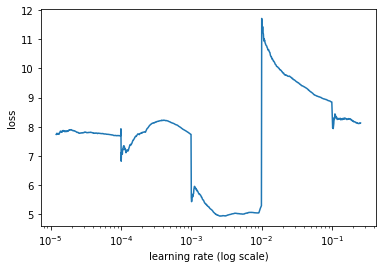

In [9]:
model = create_model(config, model_name, csDataset.input_shape, use_mixed=True)
determineLearningRate(model, datasets['train'], tf.keras.optimizers.SGD(), config.get_batch_size())

Model is AlexNet
(224, 224, 3)
Model: "alex_net_model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            multiple                  34944     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 multiple                  0         
_________________________________________________________________
re_lu_1 (ReLU)               multiple                  0         
_________________________________________________________________
batch_normalization_7 (Batch multiple                  384       
_________________________________________________________________
conv2d_6 (Conv2D)            multiple                  614656    
_________________________________________________________________
batch_normalization_8 (Batch multiple                  1024      
_________________________________________________________________
conv2d_7 (Conv2D)  

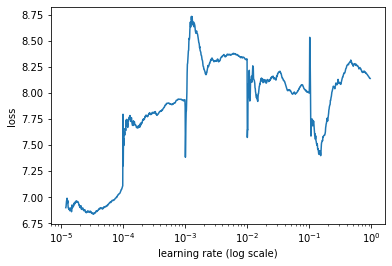

In [10]:
model = create_model(config, model_name, csDataset.input_shape, use_mixed=True)
determineLearningRate(model, datasets['train'], tf.keras.optimizers.Adam(), config.get_batch_size())

Model is AlexNet
(224, 224, 3)
Model: "alex_net_model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_10 (Conv2D)           multiple                  34944     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 multiple                  0         
_________________________________________________________________
re_lu_2 (ReLU)               multiple                  0         
_________________________________________________________________
batch_normalization_14 (Batc multiple                  384       
_________________________________________________________________
conv2d_11 (Conv2D)           multiple                  614656    
_________________________________________________________________
batch_normalization_15 (Batc multiple                  1024      
_________________________________________________________________
conv2d_12 (Conv2D) 

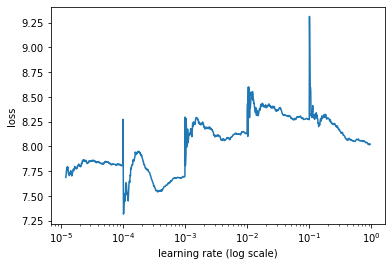

In [11]:
model = create_model(config, model_name, csDataset.input_shape, use_mixed=True)
determineLearningRate(model, datasets['train'], tf.keras.optimizers.Nadam(), config.get_batch_size())

## Optimizer

In [28]:
cosine_sched = create_scheduler(config)
opt = create_opt('adam', config)

## Model

In [29]:
model = create_model(config, 'alexnet', csDataset.input_shape, use_mixed=True)

Model is AlexNet
(224, 224, 3)
Model: "alex_net_model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           multiple                  34944     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 multiple                  0         
_________________________________________________________________
re_lu_5 (ReLU)               multiple                  0         
_________________________________________________________________
batch_normalization_35 (Batc multiple                  384       
_________________________________________________________________
conv2d_26 (Conv2D)           multiple                  614656    
_________________________________________________________________
batch_normalization_36 (Batc multiple                  1024      
_________________________________________________________________
conv2d_27 (Conv2D) 

## Run

In [30]:
datasets['train'] = datasets['train'].prefetch(1)
datasets['test'] = datasets['test'].prefetch(1)

In [31]:
history = run_model('train', model, opt, datasets, config, [chk_cb], [tb_cb])

Epoch 1/20
250/250 [==============================] - 33s 93ms/step - loss: 2.7602 - accuracy: 0.1782 - val_loss: 2.5125 - val_accuracy: 0.2368
Epoch 2/20
250/250 [==============================] - 27s 78ms/step - loss: 2.0695 - accuracy: 0.3402 - val_loss: 1.9724 - val_accuracy: 0.3774
Epoch 3/20
250/250 [==============================] - 27s 82ms/step - loss: 1.8637 - accuracy: 0.3945 - val_loss: 1.8147 - val_accuracy: 0.4242
Epoch 4/20
250/250 [==============================] - 29s 74ms/step - loss: 1.7135 - accuracy: 0.4395 - val_loss: 1.9898 - val_accuracy: 0.3847
Epoch 5/20
250/250 [==============================] - 25s 76ms/step - loss: 1.6251 - accuracy: 0.4724 - val_loss: 1.6519 - val_accuracy: 0.4832
Epoch 6/20
250/250 [==============================] - 24s 69ms/step - loss: 1.5490 - accuracy: 0.4910 - val_loss: 1.6553 - val_accuracy: 0.4805
Epoch 7/20
250/250 [==============================] - 28s 75ms/step - loss: 1.4822 - accuracy: 0.5164 - val_loss: 1.6452 - val_accuracy:

## Run TFRecords Dataset w/ custom scheduler

In [32]:
sched = create_scheduler(config, 'cyclic', {'base_lr': 1e-3, 'max_lr': 8e-3})
opt = create_opt('adam', config)

In [33]:
datasets['train'] = datasets['train'].prefetch(1)
datasets['test'] = datasets['test'].prefetch(1)
model = create_model(config, model_name, csDataset.input_shape, use_mixed=True)
history = run_model('train', model, opt, datasets, config, [chk_cb, sched], [tb_cb])

Model is AlexNet
(224, 224, 3)
Model: "alex_net_model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           multiple                  34944     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 multiple                  0         
_________________________________________________________________
re_lu_6 (ReLU)               multiple                  0         
_________________________________________________________________
batch_normalization_42 (Batc multiple                  384       
_________________________________________________________________
conv2d_31 (Conv2D)           multiple                  614656    
_________________________________________________________________
batch_normalization_43 (Batc multiple                  1024      
_________________________________________________________________
conv2d_32 (Conv2D) 

#### Best Models --> 15/16 ---> upload

In [8]:
from sklearn.metrics import confusion_matrix

acc_dict = dict()
acc_per_class_dict = dict()

with tf.device('/gpu:0'):
    model = create_model(config, model_name, csDataset.input_shape, use_mixed=True)
    model.load_weights('snapshots/snapshots-alexnet/016.h5')
    
    accs = []
    accs_per_class = []
    for x, y in datasets['test']:
        preds = model.predict(x)
        acc = (tf.math.argmax(preds, 1) == tf.math.argmax(y, 1)).numpy().sum() / len(y)
        
        matrix = confusion_matrix(tf.math.argmax(preds, 1), tf.math.argmax(y, 1))
        acc_per_class = matrix.diagonal()/matrix.sum(axis=1)
        
        accs.append(acc); accs_per_class.append(acc_per_class)
        
    accs = np.array(accs).mean()
    accs_per_class = np.array(accs_per_class).mean(1)
    
np.save('snapshots/snapshots-alexnet/acc.npy', accs)
np.save('snapshots/snapshots-alexnet/acc_classes.npy', accs_per_class)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3070, compute capability 8.6
Model is AlexNet
(224, 224, 3)
Model: "alex_net_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              multiple                  34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) multiple                  0         
_________________________________________________________________
re_lu (ReLU)                 multiple                  0         
_________________________________________________________________
batch_normalization (BatchNo multiple                  384       
_________________________________________________________________
conv2d_1 (Conv2D)            multiple       

In [12]:
history.history

{'loss': [2.6815884113311768,
  2.265125274658203,
  1.9316396713256836,
  1.761488676071167,
  1.6395443677902222,
  1.538053274154663,
  1.4479159116744995,
  1.364519476890564,
  1.3038703203201294,
  1.2399275302886963,
  1.183937430381775,
  1.1392594575881958,
  1.0855631828308105,
  1.0383915901184082,
  0.9947125911712646],
 'accuracy': [0.1521093249320984,
  0.2690996527671814,
  0.36713889241218567,
  0.41676831245422363,
  0.4564530849456787,
  0.4920724332332611,
  0.517309308052063,
  0.5468930602073669,
  0.5649372935295105,
  0.588422954082489,
  0.6070300340652466,
  0.6198204755783081,
  0.6378021836280823,
  0.6541889309883118,
  0.6668543219566345],
 'val_loss': [7.111315727233887,
  2.819671154022217,
  2.552109479904175,
  1.8975863456726074,
  1.9162068367004395,
  1.6854379177093506,
  1.7554460763931274,
  1.5338425636291504,
  1.3926090002059937,
  1.4003372192382812,
  1.4446299076080322,
  1.4095168113708496,
  1.3059744834899902,
  1.3135979175567627,
  1.32

In [13]:
import matplotlib.pyplot as plt

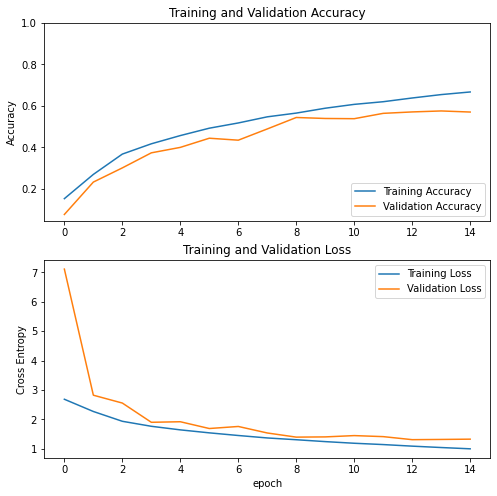

In [14]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()